In [1]:
import cv2
import mediapipe as mp
import numpy as np
import torch
from torchvision import transforms
from matplotlib import pyplot as plt
from PIL import Image

# === Biến đổi ảnh để đưa vào CNN ===
cnn_transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

def show_image(title, img):
    plt.figure(figsize=(3, 3))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis("off")
    plt.show()

def save_and_transform(img_crop, name):
    path = f"{name}.png"
    cv2.imwrite(path, img_crop)
    pil_img = Image.fromarray(cv2.cvtColor(img_crop, cv2.COLOR_BGR2RGB))
    tensor = cnn_transform(pil_img)
    print(f"{name}: shape {tensor.shape}")
    show_image(name.capitalize(), img_crop)
    return tensor

# === Đọc ảnh ===
image = cv2.imread("img/anh_01.png") 
rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
h, w, _ = image.shape

# === Khởi tạo MediaPipe ===
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, refine_landmarks=True)
results = face_mesh.process(rgb_image)

if results.multi_face_landmarks:
    landmarks = results.multi_face_landmarks[0] #
    points = [(int(pt.x * w), int(pt.y * h)) for pt in landmarks.landmark]

    # === Vẽ bounding box toàn khuôn mặt (chỉ hiển thị) ===
    x_all = [pt[0] for pt in points]
    y_all = [pt[1] for pt in points]
    fx_min, fx_max = min(x_all), max(x_all)
    fy_min, fy_max = min(y_all), max(y_all)
    cv2.rectangle(image, (fx_min, fy_min), (fx_max, fy_max), (0, 255, 0), 2)
    show_image("Face with Bounding Box", image)

    # === Cắt ảnh cho CNN ===
    pad = 10

    # Mắt phải
    right_eye_ids = [33, 160, 158, 133, 153, 144]
    right_eye_pts = [points[i] for i in right_eye_ids]
    xr = [p[0] for p in right_eye_pts]
    yr = [p[1] for p in right_eye_pts]
    r_eye_crop = image[max(min(yr)-pad,0):min(max(yr)+pad,h), max(min(xr)-pad,0):min(max(xr)+pad,w)]
    right_eye_tensor = save_and_transform(r_eye_crop, "right_eye")

    # Mắt trái
    left_eye_ids = [362, 385, 387, 263, 373, 380]
    left_eye_pts = [points[i] for i in left_eye_ids]
    xl = [p[0] for p in left_eye_pts]
    yl = [p[1] for p in left_eye_pts]
    l_eye_crop = image[max(min(yl)-pad,0):min(max(yl)+pad,h), max(min(xl)-pad,0):min(max(xl)+pad,w)]
    left_eye_tensor = save_and_transform(l_eye_crop, "left_eye")

    # Miệng
    mouth_ids = [61, 291, 78, 308, 13, 14, 17, 87, 317]
    mouth_pts = [points[i] for i in mouth_ids]
    xm = [p[0] for p in mouth_pts]
    ym = [p[1] for p in mouth_pts]
    pad_mouth = 15
    mouth_crop = image[max(min(ym)-pad_mouth,0):min(max(ym)+pad_mouth,h), max(min(xm)-pad_mouth,0):min(max(xm)+pad_mouth,w)]
    mouth_tensor = save_and_transform(mouth_crop, "mouth")

    print("\nĐã chuyển 3 vùng ảnh thành tensor: left_eye, right_eye, mouth")

else:
    print("Không phát hiện được khuôn mặt.")


KeyboardInterrupt: 

In [ ]:
import torch
import torch.nn as nn
from torchvision import models

# === Thiết bị ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Khởi tạo mô hình CNN ===
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)  # 3 channels vì ảnh màu
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(64 * 56 * 56, 128)  # kích thước sau 2 lần pool
        self.fc2 = nn.Linear(128, 4)  # số lớp tự động lấy từ dataset

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x
    
model = SimpleCNN().to(device)

# === Nạp trọng số đã huấn luyện ===
model_path = "cnn_model_02.pth"
model.load_state_dict(torch.load(model_path, map_location=device))

# === Chuyển sang chế độ dự đoán ===
model.to(device)
model.eval()

print("CNN model đã được tải và sẵn sàng.")

CNN model đã được tải và sẵn sàng.


In [ ]:
# Danh sách các lớp theo thứ tự huấn luyện
class_names = ["close_eyes", "no_yawn", "open_eyes", "yawn"]

# Logic đánh giá trạng thái buồn ngủ
def is_sleepy(pred_labels):
    sleepy_keywords = {"close_eyes", "yawn"}
    return any(label in sleepy_keywords for label in pred_labels)

In [ ]:
from PIL import Image
import torch
from torchvision import transforms

# Danh sách các lớp theo đúng thứ tự huấn luyện
class_names = ["close_eyes", "no_yawn", "open_eyes", "yawn"]

# Hàm biến đổi ảnh phù hợp với CNN
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # 3 kênh cho RGB
])

# Hàm dự đoán từ đường dẫn ảnh (dành cho CNN)
def predict_image(img_path):
    image = Image.open(img_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = model(input_tensor)
    predicted_class = class_names[outputs.argmax(1).item()]
    return predicted_class


In [ ]:
# Hàm dự đoán nhãn từ ảnh đã lưu (CNN)
def predict_image(img_path):
    image = Image.open(img_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = model(input_tensor)
    predicted_class = class_names[outputs.argmax(1).item()]
    return predicted_class

left_eye_label = predict_image("left_eye.png")
right_eye_label = predict_image("right_eye.png")
mouth_label = predict_image("mouth.png")

# Tổng hợp nhãn dự đoán
predicted_labels = [left_eye_label, right_eye_label, mouth_label]

print("Dự đoán chi tiết:")
for region, label in zip(["Left Eye", "Right Eye", "Mouth"], predicted_labels):
    print(f"{region}: {label}")

# Hàm đánh giá trạng thái buồn ngủ
def is_sleepy(pred_labels):
    sleepy_keywords = {"close_eyes", "yawn"}
    return any(label in sleepy_keywords for label in pred_labels)

# Đánh giá tổng thể
if is_sleepy(predicted_labels):
    print("\nDự đoán: BUỒN NGỦ")
else:
    print("\nDự đoán: TỈNH TÁO")


Dự đoán chi tiết:
Left Eye: close_eyes
Right Eye: open_eyes
Mouth: yawn

Dự đoán: BUỒN NGỦ


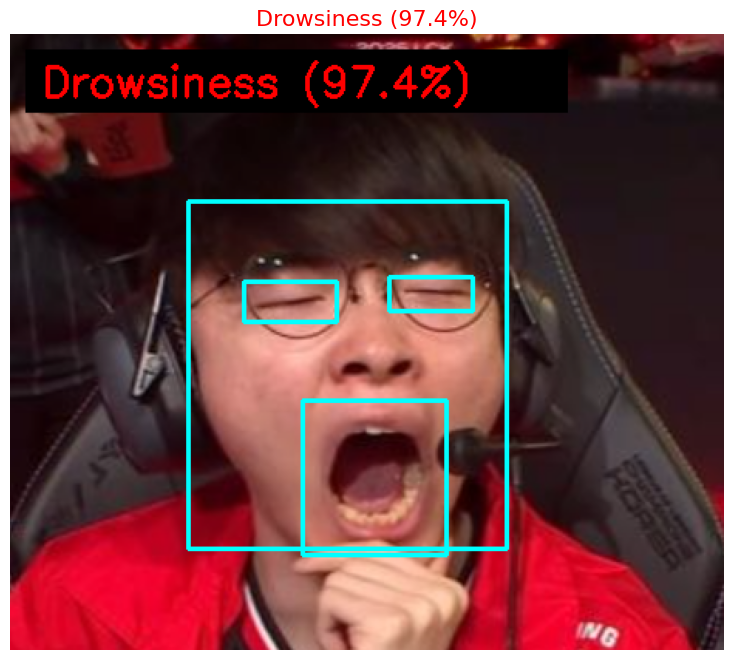

Dự đoán chi tiết:
Left Eye: close_eyes (99.8%)
Right Eye: open_eyes (66.2%)
Mouth: yawn (94.9%)
Tổng kết: DROWSINESS (97.4%)


In [ ]:
import cv2
import mediapipe as mp
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# ====== 1. Thiết lập =======
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_names = ["close_eyes", "no_yawn", "open_eyes", "yawn"]

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# ====== 2. Định nghĩa mô hình CNN =======
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(64 * 56 * 56, 128)
        self.fc2 = nn.Linear(128, 4)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = SimpleCNN().to(device)
model.load_state_dict(torch.load("cnn_model_02.pth", map_location=device))
model.eval()

# ====== 3. Hàm dự đoán ảnh =======
def predict_image(img_path):
    image = Image.open(img_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(input_tensor)
        probs = torch.nn.functional.softmax(output, dim=1)
        conf, pred = torch.max(probs, 1)
        return class_names[pred.item()], conf.item() * 100

# ====== 4. Logic đánh giá buồn ngủ =======
def is_sleepy(pred_labels):
    return any(lbl in ["close_eyes", "yawn"] for lbl in pred_labels)

# ====== 5. Phân tích ảnh đầu vào =======
def analyze_image(img_path):
    image = cv2.imread(img_path)
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    h, w, _ = image.shape

    mp_face_mesh = mp.solutions.face_mesh
    face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, refine_landmarks=True)

    results = face_mesh.process(rgb_image)
    if not results.multi_face_landmarks:
        print("Không phát hiện khuôn mặt.")
        return

    landmarks = results.multi_face_landmarks[0]
    points = [(int(pt.x * w), int(pt.y * h)) for pt in landmarks.landmark]
    pad, pad_mouth = 10, 15

    # ===== Vùng mặt =====
    x_all, y_all = zip(*points)
    face_box = (min(x_all), min(y_all), max(x_all), max(y_all))

    # ===== Mắt trái =====
    left_ids = [362, 385, 387, 263, 373, 380]
    l_pts = [(int(landmarks.landmark[i].x * w), int(landmarks.landmark[i].y * h)) for i in left_ids]
    xl, yl = zip(*l_pts)
    left_eye_crop = image[max(min(yl)-pad,0):min(max(yl)+pad,h), max(min(xl)-pad,0):min(max(xl)+pad,w)]
    cv2.imwrite("left_eye.png", left_eye_crop)
    left_eye_box = (min(xl)-pad, min(yl)-pad, max(xl)+pad, max(yl)+pad)

    # ===== Mắt phải =====
    right_ids = [33, 160, 158, 133, 153, 144]
    r_pts = [(int(landmarks.landmark[i].x * w), int(landmarks.landmark[i].y * h)) for i in right_ids]
    xr, yr = zip(*r_pts)
    right_eye_crop = image[max(min(yr)-pad,0):min(max(yr)+pad,h), max(min(xr)-pad,0):min(max(xr)+pad,w)]
    cv2.imwrite("right_eye.png", right_eye_crop)
    right_eye_box = (min(xr)-pad, min(yr)-pad, max(xr)+pad, max(yr)+pad)

    # ===== Miệng =====
    mouth_ids = [61, 291, 78, 308, 13, 14, 17, 87, 317]
    m_pts = [(int(landmarks.landmark[i].x * w), int(landmarks.landmark[i].y * h)) for i in mouth_ids]
    xm, ym = zip(*m_pts)
    mouth_crop = image[max(min(ym)-pad_mouth,0):min(max(ym)+pad_mouth,h), max(min(xm)-pad_mouth,0):min(max(xm)+pad_mouth,w)]
    cv2.imwrite("mouth.png", mouth_crop)
    mouth_box = (min(xm)-pad_mouth, min(ym)-pad_mouth, max(xm)+pad_mouth, max(ym)+pad_mouth)

    # ===== Dự đoán =====
    left_label, left_conf = predict_image("left_eye.png")
    right_label, right_conf = predict_image("right_eye.png")
    mouth_label, mouth_conf = predict_image("mouth.png")
    labels = [left_label, right_label, mouth_label]
    confs = [left_conf, right_conf, mouth_conf]

    if is_sleepy(labels):
        status = "Drowsiness"
        avg_conf = np.mean([c for l, c in zip(labels, confs) if l in ["close_eyes", "yawn"]])
        color = (0, 0, 255)
    else:
        status = "No Drowsiness"
        avg_conf = np.mean(confs)
        color = (0, 255, 0)

    # ===== Hiển thị =====
    for box in [face_box, left_eye_box, right_eye_box, mouth_box]:
        x1, y1, x2, y2 = [max(0, min(x, s)) for x, s in zip(box, [w, h, w, h])]
        cv2.rectangle(image, (x1, y1), (x2, y2), (255, 255, 0), 2)

    label_text = f"{status} ({avg_conf:.1f}%)"
    cv2.rectangle(image, (10, 10), (360, 50), (0, 0, 0), -1)
    cv2.putText(image, label_text, (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 8))
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.title(label_text, fontsize=16, color='red' if status == "Drowsiness" else 'green')
    plt.show()

    print("Dự đoán chi tiết:")
    for region, lbl, conf in zip(["Left Eye", "Right Eye", "Mouth"], labels, confs):
        print(f"{region}: {lbl} ({conf:.1f}%)")
    print(f"Tổng kết: {status.upper()} ({avg_conf:.1f}%)")

# ====== Gọi hàm với ảnh ======
analyze_image("img/anh_01.png")


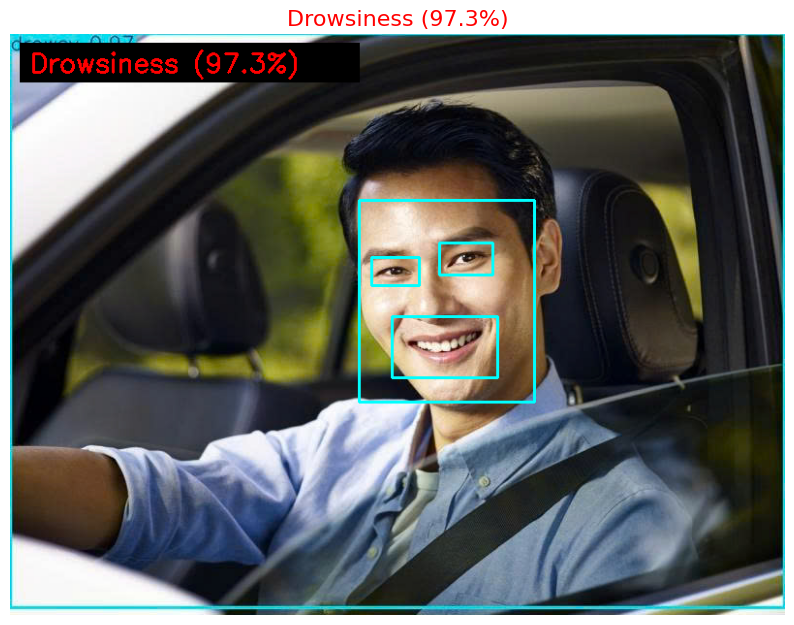

Dự đoán chi tiết:
Left Eye: open_eyes (100.0%)
Right Eye: open_eyes (100.0%)
Mouth: yawn (97.3%)
Tổng kết: DROWSINESS (97.3%)


In [ ]:
analyze_image("img/z6645719170808_efd229f17bc70d22f6c57d047eac1de4.jpg")  

In [ ]:
import cv2
import mediapipe as mp
import torch
import torch.nn as nn
import numpy as np
from PIL import Image
from torchvision import transforms

# ====== Định nghĩa mô hình CNN =======
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)  # 3 channels vì ảnh màu
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(64 * 56 * 56, 128)  # kích thước sau 2 lần pool
        self.fc2 = nn.Linear(128, 4)  # số lớp tự động lấy từ dataset

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# ====== Thiết lập mô hình và biến =======
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_names = ["close_eyes", "no_yawn", "open_eyes", "yawn"]

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

model = SimpleCNN()
model.load_state_dict(torch.load("D:/My_files/MonHoc/computer vision/project_01/cnn_model_02.pth", map_location=device))
model.to(device)
model.eval()

# ====== Các hàm xử lý =======
def predict_image(img):
    input_tensor = transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(input_tensor)
        probs = torch.nn.functional.softmax(output, dim=1)
        conf, pred = torch.max(probs, 1)
        return class_names[pred.item()], conf.item() * 100

def is_sleepy(pred_labels):
    return any(lbl in ["close_eyes", "yawn"] for lbl in pred_labels)

def crop_region(image, points, pad=10):
    h, w, _ = image.shape
    x_coords = [p[0] for p in points]
    y_coords = [p[1] for p in points]
    x_min = max(min(x_coords) - pad, 0)
    y_min = max(min(y_coords) - pad, 0)
    x_max = min(max(x_coords) + pad, w)
    y_max = min(max(y_coords) + pad, h)
    return image[y_min:y_max, x_min:x_max]

def analyze_frame(image):
    h, w, _ = image.shape

    mp_face_mesh = mp.solutions.face_mesh
    with mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, refine_landmarks=True) as face_mesh:
        rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = face_mesh.process(rgb_image)

        if not results.multi_face_landmarks:
            return image, False

        landmarks = results.multi_face_landmarks[0]
        points = [(int(pt.x * w), int(pt.y * h)) for pt in landmarks.landmark]

        left_eye_ids = [362, 385, 387, 263, 373, 380]
        right_eye_ids = [33, 160, 158, 133, 153, 144]
        mouth_ids = [61, 291, 78, 308, 13, 14, 17, 87, 317]

        left_eye_crop = crop_region(image, [points[i] for i in left_eye_ids], pad=10)
        right_eye_crop = crop_region(image, [points[i] for i in right_eye_ids], pad=10)
        mouth_crop = crop_region(image, [points[i] for i in mouth_ids], pad=15)

        left_eye_pil = Image.fromarray(cv2.cvtColor(left_eye_crop, cv2.COLOR_BGR2RGB))
        right_eye_pil = Image.fromarray(cv2.cvtColor(right_eye_crop, cv2.COLOR_BGR2RGB))
        mouth_pil = Image.fromarray(cv2.cvtColor(mouth_crop, cv2.COLOR_BGR2RGB))

        left_label, left_conf = predict_image(left_eye_pil)
        right_label, right_conf = predict_image(right_eye_pil)
        mouth_label, mouth_conf = predict_image(mouth_pil)

        sleepy_labels = [left_label, right_label, mouth_label]
        sleepy_confs = [left_conf, right_conf, mouth_conf]

        if is_sleepy(sleepy_labels):
            status = "Drowsiness"
            avg_conf = np.mean([c for l, c in zip(sleepy_labels, sleepy_confs) if l in ["close_eyes", "yawn"]])
            color = (0, 0, 255)
            is_drowsy = True
        else:
            status = "No Drowsiness"
            avg_conf = np.mean(sleepy_confs)
            color = (0, 255, 0)
            is_drowsy = False

        # Vẽ khung quanh vùng mắt và miệng
        for ids, pad_val in zip([left_eye_ids, right_eye_ids, mouth_ids], [10, 10, 15]):
            pts = [points[i] for i in ids]
            x_coords = [p[0] for p in pts]
            y_coords = [p[1] for p in pts]
            x1 = max(min(x_coords) - pad_val, 0)
            y1 = max(min(y_coords) - pad_val, 0)
            x2 = min(max(x_coords) + pad_val, w)
            y2 = min(max(y_coords) + pad_val, h)
            cv2.rectangle(image, (x1, y1), (x2, y2), (255, 255, 0), 2)

        # Viết trạng thái lên ảnh
        label = f"{status} ({avg_conf:.1f}%)"
        cv2.rectangle(image, (10, 10), (400, 50), (0, 0, 0), -1)
        cv2.putText(image, label, (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)

        return image, is_drowsy

def analyze_video(input_path, output_path, target_fps=20):
    cap = cv2.VideoCapture(input_path)
    if not cap.isOpened():
        print("Không thể mở video.")
        return

    orig_fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, target_fps, (width, height))

    frame_count = 0
    drowsy_frame_count = 0
    frame_skip_rate = int(round(orig_fps / target_fps)) if orig_fps > target_fps else 1

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        if frame_count % frame_skip_rate == 0:
            processed_frame, is_drowsy = analyze_frame(frame)
            if is_drowsy:
                drowsy_frame_count += 1

            cv2.putText(processed_frame, f"Drowsy Frames: {drowsy_frame_count}", (10, 80),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 255), 2)
            out.write(processed_frame)

        frame_count += 1

    cap.release()
    out.release()
    print(f"Xử lý hoàn tất.")
    print(f"Tổng frame đã xử lý: {frame_count}")
    print(f"Số frame có trạng thái buồn ngủ: {drowsy_frame_count}")

# ======= Chạy phân tích video =======
analyze_video(
    "img/video_02.mp4",
    "img/video_02_predict_cnn.mp4",
    target_fps=20
)


Xử lý hoàn tất.
Tổng frame đã xử lý: 313
Số frame có trạng thái buồn ngủ: 54


In [ ]:
# import cv2
# import torch
# import threading
# import queue
# import time
# import mediapipe as mp
# import numpy as np
# from PIL import Image
# from torchvision import transforms
# import torch.nn as nn

# # ==== 1. Cài đặt mô hình CNN ====
# class SimpleCNN(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)  # 3 channels vì ảnh màu
#         self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
#         self.pool = nn.MaxPool2d(2, 2)
#         self.dropout = nn.Dropout(0.3)
#         self.fc1 = nn.Linear(64 * 56 * 56, 128)  # kích thước sau 2 lần pool
#         self.fc2 = nn.Linear(128, 4)  # số lớp tự động lấy từ dataset

#     def forward(self, x):
#         x = self.pool(torch.relu(self.conv1(x)))
#         x = self.pool(torch.relu(self.conv2(x)))
#         x = x.view(x.size(0), -1)
#         x = torch.relu(self.fc1(x))
#         x = self.dropout(x)
#         x = self.fc2(x)
#         return x

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = SimpleCNN().to(device)
# model.load_state_dict(torch.load("cnn_model_02.pth", map_location=device))
# model.eval()

# class_names = ["close_eyes", "no_yawn", "open_eyes", "yawn"]
# transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize([0.5]*3, [0.5]*3)
# ])

# # ==== 2. Hàm hỗ trợ ====
# def predict_image(img):
#     input_tensor = transform(img).unsqueeze(0).to(device)
#     with torch.no_grad():
#         output = model(input_tensor)
#         probs = torch.nn.functional.softmax(output, dim=1)
#         conf, pred = torch.max(probs, 1)
#         return class_names[pred.item()], conf.item() * 100

# def is_sleepy(pred_labels):
#     return any(lbl in ["close_eyes", "yawn"] for lbl in pred_labels)

# # ==== 3. Khởi tạo FaceMesh ====
# mp_face_mesh = mp.solutions.face_mesh
# face_mesh = mp_face_mesh.FaceMesh(static_image_mode=False, max_num_faces=1, refine_landmarks=True)

# # ==== 4. Xử lý từng khung hình ====
# def analyze_frame(frame):
#     if frame is None or frame.size == 0:
#         return frame, False

#     h, w, _ = frame.shape
#     rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
#     results = face_mesh.process(rgb_frame)

#     if not results.multi_face_landmarks:
#         return frame, False

#     landmarks = results.multi_face_landmarks[0]
#     points = [(int(pt.x * w), int(pt.y * h)) for pt in landmarks.landmark]

#     left_eye_ids = [362, 385, 387, 263, 373, 380]
#     right_eye_ids = [33, 160, 158, 133, 153, 144]
#     mouth_ids = [61, 291, 78, 308, 13, 14, 17, 87, 317]

#     def crop_region(image, pts, pad=10):
#         x_coords = [p[0] for p in pts]
#         y_coords = [p[1] for p in pts]
#         x_min = max(min(x_coords) - pad, 0)
#         y_min = max(min(y_coords) - pad, 0)
#         x_max = min(max(x_coords) + pad, w)
#         y_max = min(max(y_coords) + pad, h)
#         return image[y_min:y_max, x_min:x_max]

#     left_eye_crop = crop_region(frame, [points[i] for i in left_eye_ids], pad=10)
#     right_eye_crop = crop_region(frame, [points[i] for i in right_eye_ids], pad=10)
#     mouth_crop = crop_region(frame, [points[i] for i in mouth_ids], pad=15)

#     left_eye_pil = Image.fromarray(cv2.cvtColor(left_eye_crop, cv2.COLOR_BGR2RGB))
#     right_eye_pil = Image.fromarray(cv2.cvtColor(right_eye_crop, cv2.COLOR_BGR2RGB))
#     mouth_pil = Image.fromarray(cv2.cvtColor(mouth_crop, cv2.COLOR_BGR2RGB))

#     left_label, left_conf = predict_image(left_eye_pil)
#     right_label, right_conf = predict_image(right_eye_pil)
#     mouth_label, mouth_conf = predict_image(mouth_pil)

#     sleepy_labels = [left_label, right_label, mouth_label]
#     sleepy_confs = [left_conf, right_conf, mouth_conf]

#     if is_sleepy(sleepy_labels):
#         status = "Drowsiness"
#         avg_conf = np.mean([c for l, c in zip(sleepy_labels, sleepy_confs) if l in ["close_eyes", "yawn"]])
#         color = (0, 0, 255)
#         is_drowsy = True
#     else:
#         status = "No Drowsiness"
#         avg_conf = np.mean(sleepy_confs)
#         color = (0, 255, 0)
#         is_drowsy = False

#     # Vẽ khung
#     for ids, pad_val in zip([left_eye_ids, right_eye_ids, mouth_ids], [10, 10, 15]):
#         pts = [points[i] for i in ids]
#         x_coords = [p[0] for p in pts]
#         y_coords = [p[1] for p in pts]
#         x1 = max(min(x_coords) - pad_val, 0)
#         y1 = max(min(y_coords) - pad_val, 0)
#         x2 = min(max(x_coords) + pad_val, w)
#         y2 = min(max(y_coords) + pad_val, h)
#         cv2.rectangle(frame, (x1, y1), (x2, y2), (255, 255, 0), 2)

#     label_text = f"{status} ({avg_conf:.1f}%)"
#     cv2.rectangle(frame, (10, 10), (400, 50), (0, 0, 0), -1)
#     cv2.putText(frame, label_text, (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)
    
#     # Vẽ khung toàn bộ khuôn mặt
#     all_x = [pt.x * w for pt in landmarks.landmark]
#     all_y = [pt.y * h for pt in landmarks.landmark]
#     x_min = int(max(min(all_x) - 20, 0))
#     y_min = int(max(min(all_y) - 20, 0))
#     x_max = int(min(max(all_x) + 20, w))
#     y_max = int(min(max(all_y) + 20, h))
#     cv2.rectangle(frame, (x_min, y_min), (x_max, y_max), (0, 165, 255), 2)

#     return frame, is_drowsy

# # ==== 5. Các luồng xử lý đồng thời ====
# frame_queue = queue.Queue(maxsize=10)
# processed_queue = queue.Queue()
# stop_event = threading.Event()
# drowsy_frame_count = 0
# total_frames = 0
# fps_lock = threading.Lock()
# fps = 0.0

# def read_frames():
#     cap = cv2.VideoCapture(0)
#     if not cap.isOpened():
#         print("❌ Không mở được webcam.")
#         stop_event.set()
#         return
#     while not stop_event.is_set():
#         ret, frame = cap.read()
#         if ret and not frame_queue.full():
#             frame_queue.put(frame)
#     cap.release()

# def process_frames():
#     global drowsy_frame_count, total_frames, fps
#     prev_time = time.time()
#     while not stop_event.is_set():
#         try:
#             frame = frame_queue.get(timeout=1)
#         except queue.Empty:
#             continue
#         processed_frame, is_drowsy = analyze_frame(frame)
#         total_frames += 1
#         if is_drowsy:
#             drowsy_frame_count += 1
#         now = time.time()
#         elapsed = now - prev_time
#         prev_time = now
#         with fps_lock:
#             fps = 1.0 / elapsed if elapsed > 0 else 0.0
#         text1 = f"Drowsy Frames: {drowsy_frame_count}"
#         text2 = f"FPS: {fps:.1f}"
#         cv2.putText(processed_frame, text1, (10, 80), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 255), 2)
#         cv2.putText(processed_frame, text2, (10, processed_frame.shape[0] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 0), 2)
#         if not processed_queue.full():
#             processed_queue.put(processed_frame)

# def display_frames():
#     while not stop_event.is_set():
#         try:
#             frame = processed_queue.get(timeout=1)
#         except queue.Empty:
#             continue
#         cv2.imshow("Realtime Drowsiness Detection (CNN)", frame)
#         if cv2.waitKey(1) & 0xFF == ord('q'):
#             stop_event.set()
#             break
#     cv2.destroyAllWindows()

# # ==== 6. Hàm chính khởi động hệ thống ====
# def realtime_drowsiness_detection():
#     threads = [
#         threading.Thread(target=read_frames, daemon=True),
#         threading.Thread(target=process_frames, daemon=True),
#         threading.Thread(target=display_frames, daemon=True)
#     ]
#     for t in threads: t.start()
#     for t in threads: t.join()
#     print("✅ Hệ thống đã kết thúc.")
#     print(f"🎞️ Tổng số frame: {total_frames}, Trong đó buồn ngủ: {drowsy_frame_count}")

# # ==== 7. Khởi chạy ====
# realtime_drowsiness_detection()


In [ ]:
import simpleaudio as sa
sleepy_start_time = None
ALERT_THRESHOLD = 2.0  # giây
alert_playing = False

In [ ]:
import cv2
import torch
import threading
import queue
import time
import mediapipe as mp
import numpy as np
from PIL import Image
from torchvision import transforms
import torch.nn as nn

import pygame
alert_playing = False
stop_alert_event = threading.Event()

def play_alert():
    global alert_playing
    alert_playing = True
    stop_alert_event.clear()
    pygame.mixer.init()
    pygame.mixer.music.load("img/sound.mp3") 

    pygame.mixer.music.play(-1)  

    while not stop_alert_event.is_set():
        time.sleep(0.1)

    pygame.mixer.music.stop()
    alert_playing = False
    
def stop_alert():
    global alert_playing
    if alert_playing:
        stop_alert_event.set() 

# ==== 1. Cài đặt mô hình CNN ====
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)  # 3 channels vì ảnh màu
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(64 * 56 * 56, 128)  # kích thước sau 2 lần pool
        self.fc2 = nn.Linear(128, 4)  # số lớp tự động lấy từ dataset

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)
model.load_state_dict(torch.load("cnn_model_02.pth", map_location=device))
model.eval()

class_names = ["close_eyes", "no_yawn", "open_eyes", "yawn"]
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# ==== 2. Hàm hỗ trợ ====
def predict_image(img):
    input_tensor = transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(input_tensor)
        probs = torch.nn.functional.softmax(output, dim=1)
        conf, pred = torch.max(probs, 1)
        return class_names[pred.item()], conf.item() * 100

def is_sleepy(pred_labels):
    return any(lbl in ["close_eyes", "yawn"] for lbl in pred_labels)

# ==== 3. Khởi tạo FaceMesh ====
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=False, max_num_faces=1, refine_landmarks=True)

# ==== 4. Xử lý từng khung hình ====
def analyze_frame(frame):
    if frame is None or frame.size == 0:
        return frame, False

    h, w, _ = frame.shape
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = face_mesh.process(rgb_frame)

    if not results.multi_face_landmarks:
        return frame, False

    landmarks = results.multi_face_landmarks[0]
    points = [(int(pt.x * w), int(pt.y * h)) for pt in landmarks.landmark]

    left_eye_ids = [362, 385, 387, 263, 373, 380]
    right_eye_ids = [33, 160, 158, 133, 153, 144]
    mouth_ids = [61, 291, 78, 308, 13, 14, 17, 87, 317]

    def crop_region(image, pts, pad=10):
        x_coords = [p[0] for p in pts]
        y_coords = [p[1] for p in pts]
        x_min = max(min(x_coords) - pad, 0)
        y_min = max(min(y_coords) - pad, 0)
        x_max = min(max(x_coords) + pad, w)
        y_max = min(max(y_coords) + pad, h)
        return image[y_min:y_max, x_min:x_max]

    left_eye_crop = crop_region(frame, [points[i] for i in left_eye_ids], pad=10)
    right_eye_crop = crop_region(frame, [points[i] for i in right_eye_ids], pad=10)
    mouth_crop = crop_region(frame, [points[i] for i in mouth_ids], pad=15)

    left_eye_pil = Image.fromarray(cv2.cvtColor(left_eye_crop, cv2.COLOR_BGR2RGB))
    right_eye_pil = Image.fromarray(cv2.cvtColor(right_eye_crop, cv2.COLOR_BGR2RGB))
    mouth_pil = Image.fromarray(cv2.cvtColor(mouth_crop, cv2.COLOR_BGR2RGB))

    left_label, left_conf = predict_image(left_eye_pil)
    right_label, right_conf = predict_image(right_eye_pil)
    mouth_label, mouth_conf = predict_image(mouth_pil)

    sleepy_labels = [left_label, right_label, mouth_label]
    sleepy_confs = [left_conf, right_conf, mouth_conf]

    if is_sleepy(sleepy_labels):
        status = "Drowsiness"
        avg_conf = np.mean([c for l, c in zip(sleepy_labels, sleepy_confs) if l in ["close_eyes", "yawn"]])
        color = (0, 0, 255)
        is_drowsy = True
    else:
        status = "No Drowsiness"
        avg_conf = np.mean(sleepy_confs)
        color = (0, 255, 0)
        is_drowsy = False

    # Vẽ khung
    for ids, pad_val in zip([left_eye_ids, right_eye_ids, mouth_ids], [10, 10, 15]):
        pts = [points[i] for i in ids]
        x_coords = [p[0] for p in pts]
        y_coords = [p[1] for p in pts]
        x1 = max(min(x_coords) - pad_val, 0)
        y1 = max(min(y_coords) - pad_val, 0)
        x2 = min(max(x_coords) + pad_val, w)
        y2 = min(max(y_coords) + pad_val, h)
        cv2.rectangle(frame, (x1, y1), (x2, y2), (255, 255, 0), 2)

    label_text = f"{status} ({avg_conf:.1f}%)"
    cv2.rectangle(frame, (10, 10), (400, 50), (0, 0, 0), -1)
    cv2.putText(frame, label_text, (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)
    
    # Vẽ khung toàn bộ khuôn mặt
    all_x = [pt.x * w for pt in landmarks.landmark]
    all_y = [pt.y * h for pt in landmarks.landmark]
    x_min = int(max(min(all_x) - 20, 0))
    y_min = int(max(min(all_y) - 20, 0))
    x_max = int(min(max(all_x) + 20, w))
    y_max = int(min(max(all_y) + 20, h))
    cv2.rectangle(frame, (x_min, y_min), (x_max, y_max), (0, 165, 255), 2)

    return frame, is_drowsy

# ==== 5. Các luồng xử lý đồng thời ====
frame_queue = queue.Queue(maxsize=10)
processed_queue = queue.Queue()
stop_event = threading.Event()
drowsy_frame_count = 0
total_frames = 0
fps_lock = threading.Lock()
fps = 0.0

def read_frames():
    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        print("Không mở được webcam.")
        stop_event.set()
        return
    while not stop_event.is_set():
        ret, frame = cap.read()
        if ret and not frame_queue.full():
            frame_queue.put(frame)
    cap.release()

def process_frames():
    global drowsy_frame_count, total_frames, fps, sleepy_start_time, alert_playing
    prev_time = time.time()
    sleepy_start_time = None
    ALERT_THRESHOLD = 2.0  # Giây

    while not stop_event.is_set():
        try:
            frame = frame_queue.get(timeout=1)
        except queue.Empty:
            continue

        processed_frame, is_drowsy = analyze_frame(frame)
        total_frames += 1

        # Kiểm tra trạng thái buồn ngủ kéo dài
        now = time.time()
        if is_drowsy:
            drowsy_frame_count += 1
            if sleepy_start_time is None:
                sleepy_start_time = now
            elif now - sleepy_start_time >= ALERT_THRESHOLD:
                if not alert_playing:
                    threading.Thread(target=play_alert, daemon=True).start()
        else:
            sleepy_start_time = None
            if alert_playing:
                stop_alert_event.set() 

        # Tính FPS
        elapsed = now - prev_time
        prev_time = now
        with fps_lock:
            fps = 1.0 / elapsed if elapsed > 0 else 0.0

        # Vẽ thông tin lên khung hình
        text1 = f"Drowsy Frames: {drowsy_frame_count}"
        text2 = f"FPS: {fps:.1f}"
        cv2.putText(processed_frame, text1, (10, 80), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 255), 2)
        cv2.putText(processed_frame, text2, (10, processed_frame.shape[0] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 0), 2)

        # Đưa vào hàng đợi hiển thị
        if not processed_queue.full():
            processed_queue.put(processed_frame)

def display_frames():
    while not stop_event.is_set():
        try:
            frame = processed_queue.get(timeout=1)
        except queue.Empty:
            continue
        cv2.imshow("Realtime Drowsiness Detection (CNN)", frame)
        key = cv2.waitKey(1) & 0xFF
        if key == ord('q'):
            stop_event.set()
            break
        elif key == ord('s'):
            stop_alert()
    cv2.destroyAllWindows()

# ==== 6. Hàm chính khởi động hệ thống ====
def realtime_drowsiness_detection():
    threads = [
        threading.Thread(target=read_frames, daemon=True),
        threading.Thread(target=process_frames, daemon=True),
        threading.Thread(target=display_frames, daemon=True)
    ]
    for t in threads: t.start()
    for t in threads: t.join()
    print("Hệ thống đã kết thúc.")
    print(f"Tổng số frame: {total_frames}, Trong đó buồn ngủ: {drowsy_frame_count}")

# ==== 7. Khởi chạy ====
realtime_drowsiness_detection()

Hệ thống đã kết thúc.
Tổng số frame: 146, Trong đó buồn ngủ: 67


In [ ]:
stop_alert_event.set()